# Amazon Lookout for Vision Lab

## Environmental variables

In [27]:
import os
import time
import boto3
from IPython.display import display, Image as IImage
from IPython.display import JSON
from datetime import datetime

session = boto3.session.Session()
print("session: ", session)

region_nm = session.region_name
print("region: ", region_nm)

# bucket_nm = f"l4v-s3-bucket-jamie-{datetime.today().strftime('%Y-%m-%d')}"
bucket_nm = "l4v-s3-bucket-jamie-2022-03-28"
print("bucket name: ", bucket_nm)

project_nm = "circuit_project"
print("project name: ", project_nm)

# os
os.environ["BUCKET"] = bucket_nm
os.environ["REGION"] = region_nm

session:  Session(region_name='ap-northeast-2')
region:  ap-northeast-2
bucket name:  l4v-s3-bucket-jamie-2022-03-28
project name:  circuit_project


In [28]:
s3_client = boto3.client('s3')
lookout4vision = boto3.client('lookoutvision')

### Create S3 Bucket

In [3]:
!aws s3api create-bucket --bucket $BUCKET --create-bucket-configuration LocationConstraint=$REGION


An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


## EDA for Circuitboard Image Train/Test Data

### Make Circuitboard Dataframe

In [29]:
import numpy as np
import pandas as pd


IMAGE_DIR = './circuitboard'

def make_circuitboard_dataframe(image_dir=IMAGE_DIR):
    train_paths = []
    train_labels = []
    
    for dirname, _, filenames in os.walk(image_dir):
        for filename in filenames:
            if '.jpg' in filename:
                file_path = dirname + '/' + filename
                dataset = file_path.split('/')[2]; label = file_path.split('/')[3]
                if dataset == 'train':
                    train_paths.append(file_path)
                    train_labels.append(label)
    
    data_df = pd.DataFrame(
        {
            'path': train_paths,
            'label': train_labels
        }
    )
    
    return data_df

In [30]:
IMAGE_DIR = './circuitboard'


pd.set_option('display.max_colwidth', 200)

data_df = make_circuitboard_dataframe(image_dir=IMAGE_DIR)
print("data_df shape: ", data_df.shape)

data_df shape:  (40, 2)


In [31]:
data_df.head()

,path,label
0,./circuitboard/train/normal/train-normal_18.jpg,normal
1,./circuitboard/train/normal/train-normal_16.jpg,normal
2,./circuitboard/train/normal/train-normal_3.jpg,normal
3,./circuitboard/train/normal/train-normal_11.jpg,normal
4,./circuitboard/train/normal/train-normal_8.jpg,normal


In [32]:
data_df['label'].value_counts()

anomaly    20
normal     20
Name: label, dtype: int64

### View the circuitboard images

In [33]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


def show_grid_images(image_path_list, ncols=6, title=None):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for col in range(ncols):
        image = cv2.cvtColor(cv2.imread(image_path_list[col]), cv2.COLOR_BGR2RGB)
        axs[col].imshow(image)
        axs[col].set_title(title)

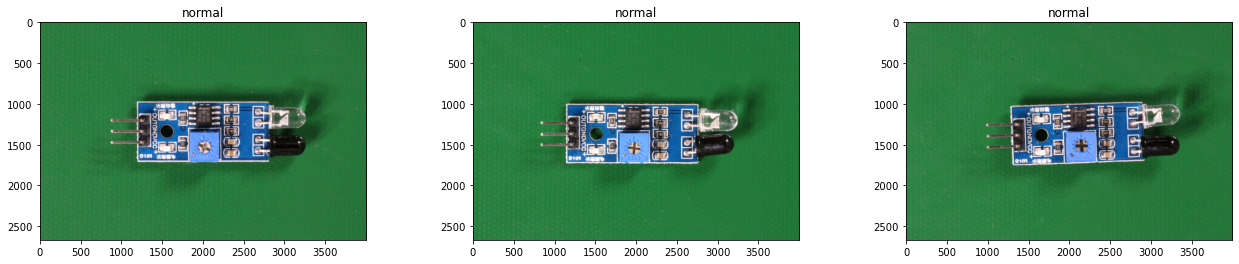

In [34]:
train_normal_image_list = data_df[data_df['label']=='normal']['path'].iloc[:3].tolist()
# print("train normal image list: ", train_normal_image_list)

show_grid_images(train_normal_image_list, ncols=3, title='normal')

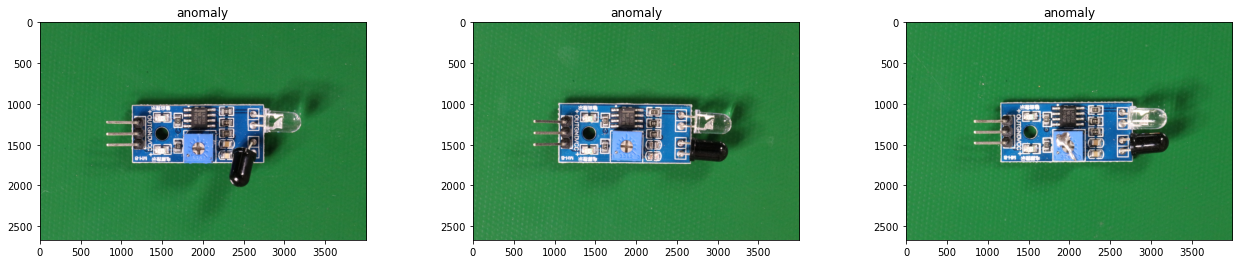

In [35]:
train_anomaly_image_list = data_df[data_df['label']=='anomaly']['path'].iloc[:3].tolist()

show_grid_images(train_anomaly_image_list, ncols=3, title='anomaly')

## Image Preparation

### Generate the manifest files
- source-ref: this is the location for each file
- auto-label: the value for each label (0=bad, 1=good)

In [11]:
import json


dttm = datetime.now().strftime("%Y-%m-%dT%H:%M:%S.%f")

datasets = ["train", "test"]

for dataset in datasets:
    folders = os.listdir("./circuitboard/{}".format(dataset))
    with open("{}.manifest".format(dataset), "w") as f:
        for folder in folders:
            filecount = 0
            files = os.listdir("./circuitboard/{}/{}".format(dataset, folder))
            label = 1
            if folder == "anomaly":
                label = 0
            for file in files:
                filecount += 1
                
                if filecount > 20:
                    break
                
                manifest = {
                    "source-ref": "s3://{}/{}/{}/{}/{}".format(bucket_nm, project_nm, dataset, folder, file),
                    "auto-label": label,
                    "auto-label-metadata": {
                        "confidence": 1,
                        "job-name": "labeling-job/auto-label",
                        "class-name": folder,
                        "human-annotated": "yes",
                        "creation-date": dttm,
                        "type": "groundtruth/image-classification"
                    }
                }
                
                f.write(json.dumps(manifest) + "\n")

### Upload manifest files and images to S3

In [12]:
!aws s3 cp train.manifest s3://{bucket_nm}/{project_nm}/train.manifest
!aws s3 cp test.manifest s3://{bucket_nm}/{project_nm}/test.manifest

upload: ./train.manifest to s3://l4v-s3-bucket-jamie-2022-03-28/circuit_project/train.manifest
upload: ./test.manifest to s3://l4v-s3-bucket-jamie-2022-03-28/circuit_project/test.manifest


In [13]:
!aws s3 cp circuitboard/train/normal s3://{bucket_nm}/{project_nm}/train/normal --recursive
!aws s3 cp circuitboard/train/anomaly s3://{bucket_nm}/{project_nm}/train/anomaly --recursive

upload: circuitboard/train/normal/train-normal_1.jpg to s3://l4v-s3-bucket-jamie-2022-03-28/circuit_project/train/normal/train-normal_1.jpg
upload: circuitboard/train/normal/train-normal_10.jpg to s3://l4v-s3-bucket-jamie-2022-03-28/circuit_project/train/normal/train-normal_10.jpg
upload: circuitboard/train/normal/train-normal_12.jpg to s3://l4v-s3-bucket-jamie-2022-03-28/circuit_project/train/normal/train-normal_12.jpg
upload: circuitboard/train/normal/train-normal_11.jpg to s3://l4v-s3-bucket-jamie-2022-03-28/circuit_project/train/normal/train-normal_11.jpg
upload: circuitboard/train/normal/train-normal_17.jpg to s3://l4v-s3-bucket-jamie-2022-03-28/circuit_project/train/normal/train-normal_17.jpg
upload: circuitboard/train/normal/train-normal_18.jpg to s3://l4v-s3-bucket-jamie-2022-03-28/circuit_project/train/normal/train-normal_18.jpg
upload: circuitboard/train/normal/train-normal_2.jpg to s3://l4v-s3-bucket-jamie-2022-03-28/circuit_project/train/normal/train-normal_2.jpg
upload: ci

In [14]:
!aws s3 cp circuitboard/test/normal s3://{bucket_nm}/{project_nm}/test/normal --recursive
!aws s3 cp circuitboard/test/anomaly s3://{bucket_nm}/{project_nm}/test/anomaly --recursive

upload: circuitboard/test/normal/test-normal_11.jpg to s3://l4v-s3-bucket-jamie-2022-03-28/circuit_project/test/normal/test-normal_11.jpg
upload: circuitboard/test/normal/test-normal_1.jpg to s3://l4v-s3-bucket-jamie-2022-03-28/circuit_project/test/normal/test-normal_1.jpg
upload: circuitboard/test/normal/test-normal_10.jpg to s3://l4v-s3-bucket-jamie-2022-03-28/circuit_project/test/normal/test-normal_10.jpg
upload: circuitboard/test/normal/test-normal_2.jpg to s3://l4v-s3-bucket-jamie-2022-03-28/circuit_project/test/normal/test-normal_2.jpg
upload: circuitboard/test/normal/test-normal_17.jpg to s3://l4v-s3-bucket-jamie-2022-03-28/circuit_project/test/normal/test-normal_17.jpg
upload: circuitboard/test/normal/test-normal_18.jpg to s3://l4v-s3-bucket-jamie-2022-03-28/circuit_project/test/normal/test-normal_18.jpg
upload: circuitboard/test/normal/test-normal_12.jpg to s3://l4v-s3-bucket-jamie-2022-03-28/circuit_project/test/normal/test-normal_12.jpg
upload: circuitboard/test/normal/test-

## Creating Amazon Lookout for Vision Project using boto3 Python SDK

### Creating Project

In [16]:
l4v_project = lookout4vision.create_project(ProjectName=project_nm)

l4v_project_arn = l4v_project['ProjectMetadata']['ProjectArn']
print("Lookout for vision arn: ", l4v_project_arn)

### Creating Training Dataset

In [16]:
dataset_type = "train"
manifest_file = project_nm + '/train.manifest'

dataset = json.loads(
    '{ "GroundTruthManifest": { "S3Object": { "Bucket": "' + bucket_nm + '", "Key": "'+ manifest_file + '" } } }'
)

l4v_project_create_dataset_response = lookout4vision.create_dataset(
    ProjectName=project_nm,
    DatasetType=dataset_type,
    DatasetSource=dataset
)

In [26]:
print('Dataset Status: ', l4v_project_create_dataset_response['DatasetMetadata']['Status'])
print('Dataset Status Message: ', l4v_project_create_dataset_response['DatasetMetadata']['StatusMessage'])
print('Dataset Type: ', l4v_project_create_dataset_response['DatasetMetadata']['DatasetType'])

Dataset Status:  CREATE_IN_PROGRESS
Dataset Status Message:  The dataset is creating.
Dataset Type:  train


In [27]:
l4v_project_create_dataset_response['DatasetMetadata']

{'DatasetType': 'train',
 'CreationTimestamp': datetime.datetime(2022, 3, 28, 12, 17, 6, 555000, tzinfo=tzlocal()),
 'Status': 'CREATE_IN_PROGRESS',
 'StatusMessage': 'The dataset is creating.'}

In [31]:
from IPython.display import display, Image as IImage
from IPython.display import JSON


chk_status = True
start_time = time.time()

while chk_status:
    time.sleep(5)
    print('.', end='')
    l4v_project_create_dataset_status = lookout4vision.describe_dataset(
        ProjectName=project_nm,
        DatasetType="train"
    )
    
    if l4v_project_create_dataset_status['DatasetDescription']['Status'] != 'CREATE_IN_PROGRESS':
        chk_status = False
    if (time.time() - start_time) > 3600:
        chk_status = False
    

JSON(l4v_project_create_dataset_status)

.

<IPython.core.display.JSON object>

### Creating Test Dataset

In [33]:
dataset_type = "test"
manifest_file = project_nm + "/" + "test.manifest"

dataset = json.loads(
    '{ "GroundTruthManifest": { "S3Object": { "Bucket": "' + bucket_nm + '", "Key": "'+ manifest_file + '" } } }'
)

l4v_project_create_dataset_response = lookout4vision.create_dataset(
    ProjectName=project_nm,
    DatasetType=dataset_type,
    DatasetSource=dataset
)

In [35]:
chk_status = True
start_time = time.time()

while chk_status:
    time.sleep(5)
    print('.', end='')
    l4v_project_create_dataset_status = lookout4vision.describe_dataset(
        ProjectName=project_nm,
        DatasetType="test"
    )
    
    if l4v_project_create_dataset_status['DatasetDescription']['Status'] != 'CREATE_IN_PROGRESS':
        chk_status = False
    if (time.time() - start_time) > 3600:
        chk_status = False
    

JSON(l4v_project_create_dataset_status)

.

<IPython.core.display.JSON object>

### Creating/training Model

In [17]:
output_bucket_nm = bucket_nm
print("output bucket name: ", output_bucket_nm)

output bucket name:  l4v-s3-bucket-jamie-2022-03-28


In [18]:
output_folder = project_nm + "/" + "model/"
print("output folder name: ", output_folder)

output folder name:  circuit_project/model/


In [21]:
from IPython.display import display, Image as IImage
from IPython.display import JSON


output_config = dataset = json.loads(
    '{ "S3Location": { "Bucket": "' + output_bucket_nm + '", "Prefix": "'+ output_folder + '" } } '
)

JSON(output_config)

<IPython.core.display.JSON object>

In [23]:
l4v_project_create_model_status = lookout4vision.create_model(
    ProjectName=project_nm,
    OutputConfig=output_config
)

print("Project ARN: ", l4v_project_create_model_status['ModelMetadata']['ModelArn'])
print("Project Model Version: ", l4v_project_create_model_status['ModelMetadata']['ModelVersion'])
print("Project Model Creation Status: ", l4v_project_create_model_status['ModelMetadata']['Status'])
print("Project Model Status Message: ", l4v_project_create_model_status['ModelMetadata']['StatusMessage'])

Project ARN:  arn:aws:lookoutvision:ap-northeast-2:487256341028:model/circuit_project/1
Project Model Version:  1
Project Model Creation Status:  TRAINING
Project Model Status Message:  The model is being trained.


### Wait for the model training to complete

In [ ]:
chk_status = True
start_time = time.time()

while chk_status:
    time.sleep(5)
    print('.', end='')
    l4v_project_create_model_status = lookout4vision.describe_model(
        ProjectName=project_nm,
        ModelVersion='1'
    )
    
    if l4v_project_create_model_status['ModelDescription']['Status'] != 'TRAINING':
        chk_status = False

print('Done!')

JSON(l4v_project_create_model_status)

## Model Depolyment

### Hosting the trained model

In [40]:
model_version = '1'
min_inference_units=1

print(f"Starting model version {model_version} for project {project_nm}")

l4v_project_start_model_response = lookout4vision.start_model(
    ProjectName=project_nm,
    ModelVersion=model_version,
    MinInferenceUnits=min_inference_units
)

print(f'Status: {l4v_project_start_model_response["Status"]}')

Starting model version 1 for project circuit_project
Status: STARTING_HOSTING


### Wait for model hosting to complete

In [41]:
chk_status = True
start_time = time.time()

while chk_status:
    time.sleep(10)
    print('.', end='')
    l4v_project_start_model_status = lookout4vision.describe_model(
        ProjectName=project_nm,
        ModelVersion=model_version
    )
    
    if l4v_project_start_model_status['ModelDescription']['Status'] != 'STARTING_HOSTING':
        chk_status = False

print('Done!')

JSON(l4v_project_start_model_status)

.............Done!


<IPython.core.display.JSON object>

## Make Predictions

### Pick an anomaly image from the extra images

In [44]:
pred_photo = 'circuitboard/extra_images/extra_images-anomaly_3.jpg'
model_version = '1'


with open(pred_photo, 'rb') as image:
    l4v_project_predict_response = lookout4vision.detect_anomalies(
        ProjectName=project_nm,
        ContentType='image/jpeg',
        Body=image.read(),
        ModelVersion=model_version
    )

print('Anomalous?: ', str(l4v_project_predict_response['DetectAnomalyResult']['IsAnomalous']))
print('Confidence: ', str(l4v_project_predict_response['DetectAnomalyResult']['Confidence']))

Anomalous?:  True
Confidence:  0.9189378023147583


### Pick an normal image from the extra images

In [45]:
pred_photo = 'circuitboard/extra_images/extra_images-normal_1.jpg'
model_version = '1'

with open(pred_photo, 'rb') as image:
    l4v_project_predict_response = lookout4vision.detect_anomalies(
        ProjectName=project_nm,
        ContentType='image/jpeg',
        Body=image.read(),
        ModelVersion=model_version
    )

print('Anomalous?: ', str(l4v_project_predict_response['DetectAnomalyResult']['IsAnomalous']))
print('Confidence: ', str(l4v_project_predict_response['DetectAnomalyResult']['Confidence']))

Anomalous?:  False
Confidence:  0.9803691506385803


## Stop Model

In [46]:
model_version = '1'

print(f'Stopping model version: {model_version} for project {project_nm}')

l4v_project_stop_model_response = lookout4vision.stop_model(
    ProjectName=project_nm,
    ModelVersion=model_version
)

print(f'Status: {l4v_project_stop_model_response["Status"]}')

Stopping model version: 1 for project circuit_project
Status: STOPPING_HOSTING


### wait for model stopping to complete

In [47]:
chk_status = True
start_time = time.time()

while chk_status:
    time.sleep(10)
    print('.', end='')
    l4v_project_stop_model_status = lookout4vision.describe_model(
        ProjectName=project_nm,
        ModelVersion=model_version
    )
    
    if l4v_project_stop_model_status['ModelDescription']['Status'] != 'STOPPING_HOSTING':
        chk_status = False

print('Done!')

JSON(l4v_project_stop_model_status)

.Done!


<IPython.core.display.JSON object>